In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os
import keras
from keras_unet.models import custom_unet

Populating the interactive namespace from numpy and matplotlib


2023-03-30 21:05:47.908357: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
DATAPATH = '/raid/mpsych/CACTAS/DATA/ESUS/'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')

In [3]:
images = np.load(images_file)
labels = np.load(labels_file)

In [4]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [5]:
p = np.random.permutation(len(images))

In [6]:
images = images[p]
labels = labels[p]

In [7]:
labels = labels.astype(np.float64)

In [8]:
images = images.astype(np.float64)

for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [9]:
images.shape, labels.shape

((766, 512, 512, 1), (766, 512, 512, 1))

In [10]:
import json

In [11]:
with open("image_data_v3.json", "r") as fp:
    image_data = json.load(fp)
with open("label_data_v3.json", "r") as fp:
    label_data = json.load(fp)

In [12]:
X_train = images[0:image_data['82']]
y_train = labels[0:label_data['82']]
X_val = images[image_data['82']:]
y_val = labels[label_data['82']:]

In [13]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=5.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=40,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 512, 512, 1) (2, 512, 512, 1)


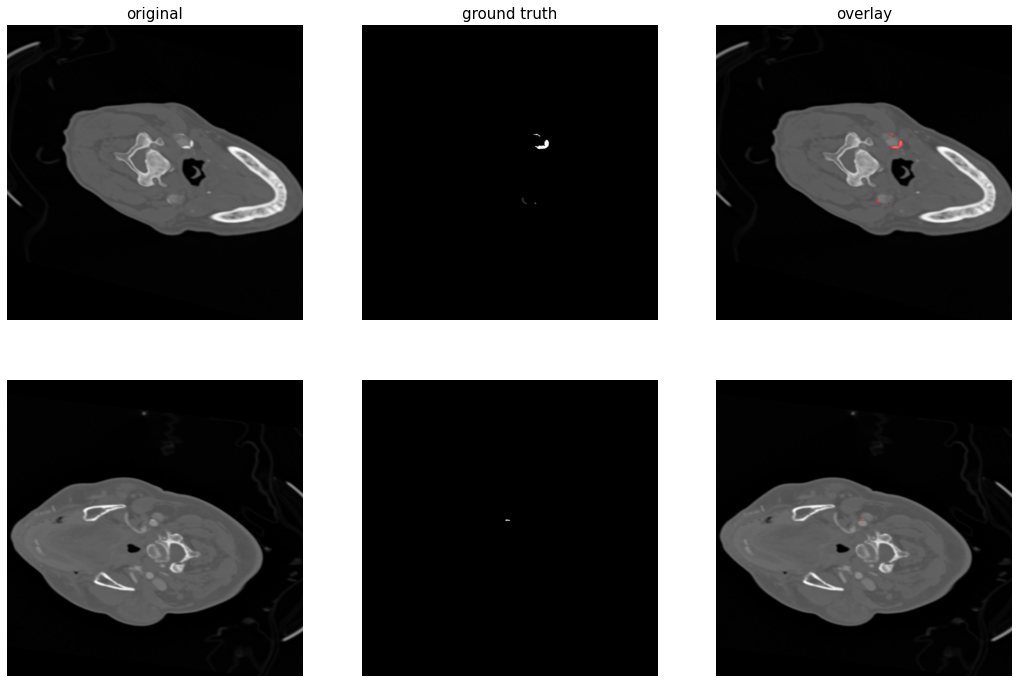

In [14]:
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)


In [15]:
model = custom_unet(
    input_shape=(512, 512, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.5,
    output_activation='sigmoid')

2023-03-30 21:06:41.044749: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-30 21:06:41.195053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-03-30 21:06:41.195095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-30 21:06:41.245880: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-30 21:06:41.245913: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-30 21:06:41.265754: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [16]:
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from tensorflow.keras.optimizers import Adam

In [17]:
model.compile(optimizer = Adam(),    
              loss='binary_crossentropy', 
              metrics=[iou, iou_thresholded])

In [19]:
history = model.fit(X_train, 
                    y_train, 
                    16, 
                    epochs=200,
                    validation_data=(X_val, y_val))

Epoch 1/200
38/38 [==============================] - 36s 662ms/step - loss: 0.5442 - iou: 2.7103e-04 - iou_thresholded: 5.7862e-04 - val_loss: 0.0053 - val_iou: 8.2898e-04 - val_iou_thresholded: 6.3783e-04
Epoch 2/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0057 - iou: 5.8812e-04 - iou_thresholded: 6.2811e-04 - val_loss: 0.0035 - val_iou: 9.2304e-04 - val_iou_thresholded: 6.3783e-04
Epoch 3/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0046 - iou: 8.6958e-04 - iou_thresholded: 6.0147e-04 - val_loss: 0.0033 - val_iou: 0.0011 - val_iou_thresholded: 6.3783e-04
Epoch 4/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0042 - iou: 0.0011 - iou_thresholded: 5.2661e-04 - val_loss: 0.0033 - val_iou: 0.0011 - val_iou_thresholded: 6.3783e-04
Epoch 5/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0040 - iou: 0.0015 - iou_thresholded: 5.5351e-04 - val_loss: 0.0030 - val_iou: 0.0017 - val_iou_thresholded: 6

Epoch 43/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0057 - iou: 6.0575e-04 - iou_thresholded: 5.5254e-04 - val_loss: 0.0032 - val_iou: 0.0012 - val_iou_thresholded: 6.3783e-04
Epoch 44/200
38/38 [==============================] - 14s 364ms/step - loss: 0.0040 - iou: 0.0014 - iou_thresholded: 5.9010e-04 - val_loss: 0.0031 - val_iou: 0.0012 - val_iou_thresholded: 6.3783e-04
Epoch 45/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0037 - iou: 0.0020 - iou_thresholded: 6.2663e-04 - val_loss: 0.0034 - val_iou: 8.9336e-04 - val_iou_thresholded: 6.3783e-04
Epoch 46/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0035 - iou: 0.0028 - iou_thresholded: 6.6358e-04 - val_loss: 0.0036 - val_iou: 8.1353e-04 - val_iou_thresholded: 6.3783e-04
Epoch 47/200
38/38 [==============================] - 14s 364ms/step - loss: 0.0034 - iou: 0.0032 - iou_thresholded: 5.4940e-04 - val_loss: 0.0033 - val_iou: 0.0011 - val_iou_thresholded: 6.37

38/38 [==============================] - 14s 365ms/step - loss: 0.0019 - iou: 0.1363 - iou_thresholded: 0.2036 - val_loss: 0.0016 - val_iou: 0.1222 - val_iou_thresholded: 0.1138
Epoch 86/200
38/38 [==============================] - 14s 364ms/step - loss: 0.0019 - iou: 0.1344 - iou_thresholded: 0.1980 - val_loss: 0.0014 - val_iou: 0.1954 - val_iou_thresholded: 0.2535
Epoch 87/200
38/38 [==============================] - 14s 369ms/step - loss: 0.0019 - iou: 0.1525 - iou_thresholded: 0.2221 - val_loss: 0.0014 - val_iou: 0.1634 - val_iou_thresholded: 0.2300
Epoch 88/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0018 - iou: 0.1572 - iou_thresholded: 0.2338 - val_loss: 0.0014 - val_iou: 0.1936 - val_iou_thresholded: 0.2692
Epoch 89/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0018 - iou: 0.1518 - iou_thresholded: 0.2275 - val_loss: 0.0014 - val_iou: 0.1928 - val_iou_thresholded: 0.2536
Epoch 90/200
38/38 [==============================] - 14s 

38/38 [==============================] - 14s 365ms/step - loss: 0.0018 - iou: 0.1298 - iou_thresholded: 0.1739 - val_loss: 0.0012 - val_iou: 0.1630 - val_iou_thresholded: 0.2018
Epoch 128/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0017 - iou: 0.1187 - iou_thresholded: 0.1597 - val_loss: 0.0019 - val_iou: 0.0385 - val_iou_thresholded: 0.0114
Epoch 129/200
38/38 [==============================] - 14s 365ms/step - loss: 0.0019 - iou: 0.1069 - iou_thresholded: 0.1430 - val_loss: 7.5419e-04 - val_iou: 0.1977 - val_iou_thresholded: 0.2508
Epoch 130/200
38/38 [==============================] - 14s 364ms/step - loss: 0.0018 - iou: 0.1079 - iou_thresholded: 0.1475 - val_loss: 8.2365e-04 - val_iou: 0.1263 - val_iou_thresholded: 0.2637
Epoch 131/200
38/38 [==============================] - 14s 367ms/step - loss: 0.0027 - iou: 0.0477 - iou_thresholded: 0.0479 - val_loss: 0.0022 - val_iou: 0.0307 - val_iou_thresholded: 6.3770e-04
Epoch 132/200
38/38 [=====================

38/38 [==============================] - 14s 364ms/step - loss: 0.0034 - iou: 0.0043 - iou_thresholded: 5.7496e-04 - val_loss: 0.0025 - val_iou: 0.0092 - val_iou_thresholded: 6.3783e-04
Epoch 170/200
38/38 [==============================] - 14s 367ms/step - loss: 0.0030 - iou: 0.0086 - iou_thresholded: 6.0352e-04 - val_loss: 0.0022 - val_iou: 0.0153 - val_iou_thresholded: 6.3783e-04
Epoch 171/200
38/38 [==============================] - 14s 366ms/step - loss: 0.0029 - iou: 0.0127 - iou_thresholded: 6.0215e-04 - val_loss: 0.0021 - val_iou: 0.0184 - val_iou_thresholded: 6.3783e-04
Epoch 172/200
38/38 [==============================] - 14s 364ms/step - loss: 0.0026 - iou: 0.0232 - iou_thresholded: 0.0016 - val_loss: 0.0019 - val_iou: 0.0465 - val_iou_thresholded: 0.0023
Epoch 173/200
38/38 [==============================] - 14s 367ms/step - loss: 0.0024 - iou: 0.0474 - iou_thresholded: 0.0302 - val_loss: 0.0019 - val_iou: 0.0627 - val_iou_thresholded: 0.0632
Epoch 174/200
38/38 [=========

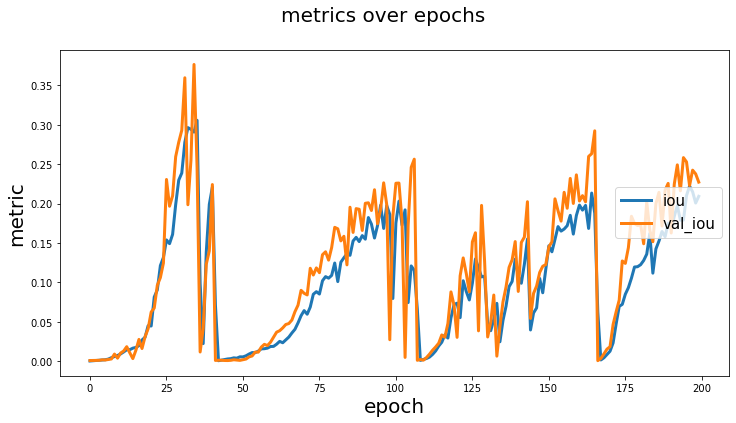

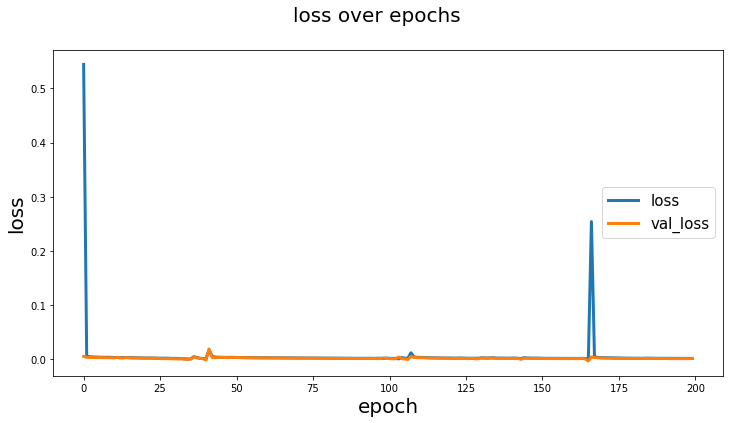

In [20]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [21]:
y_pred = model.predict(X_val)

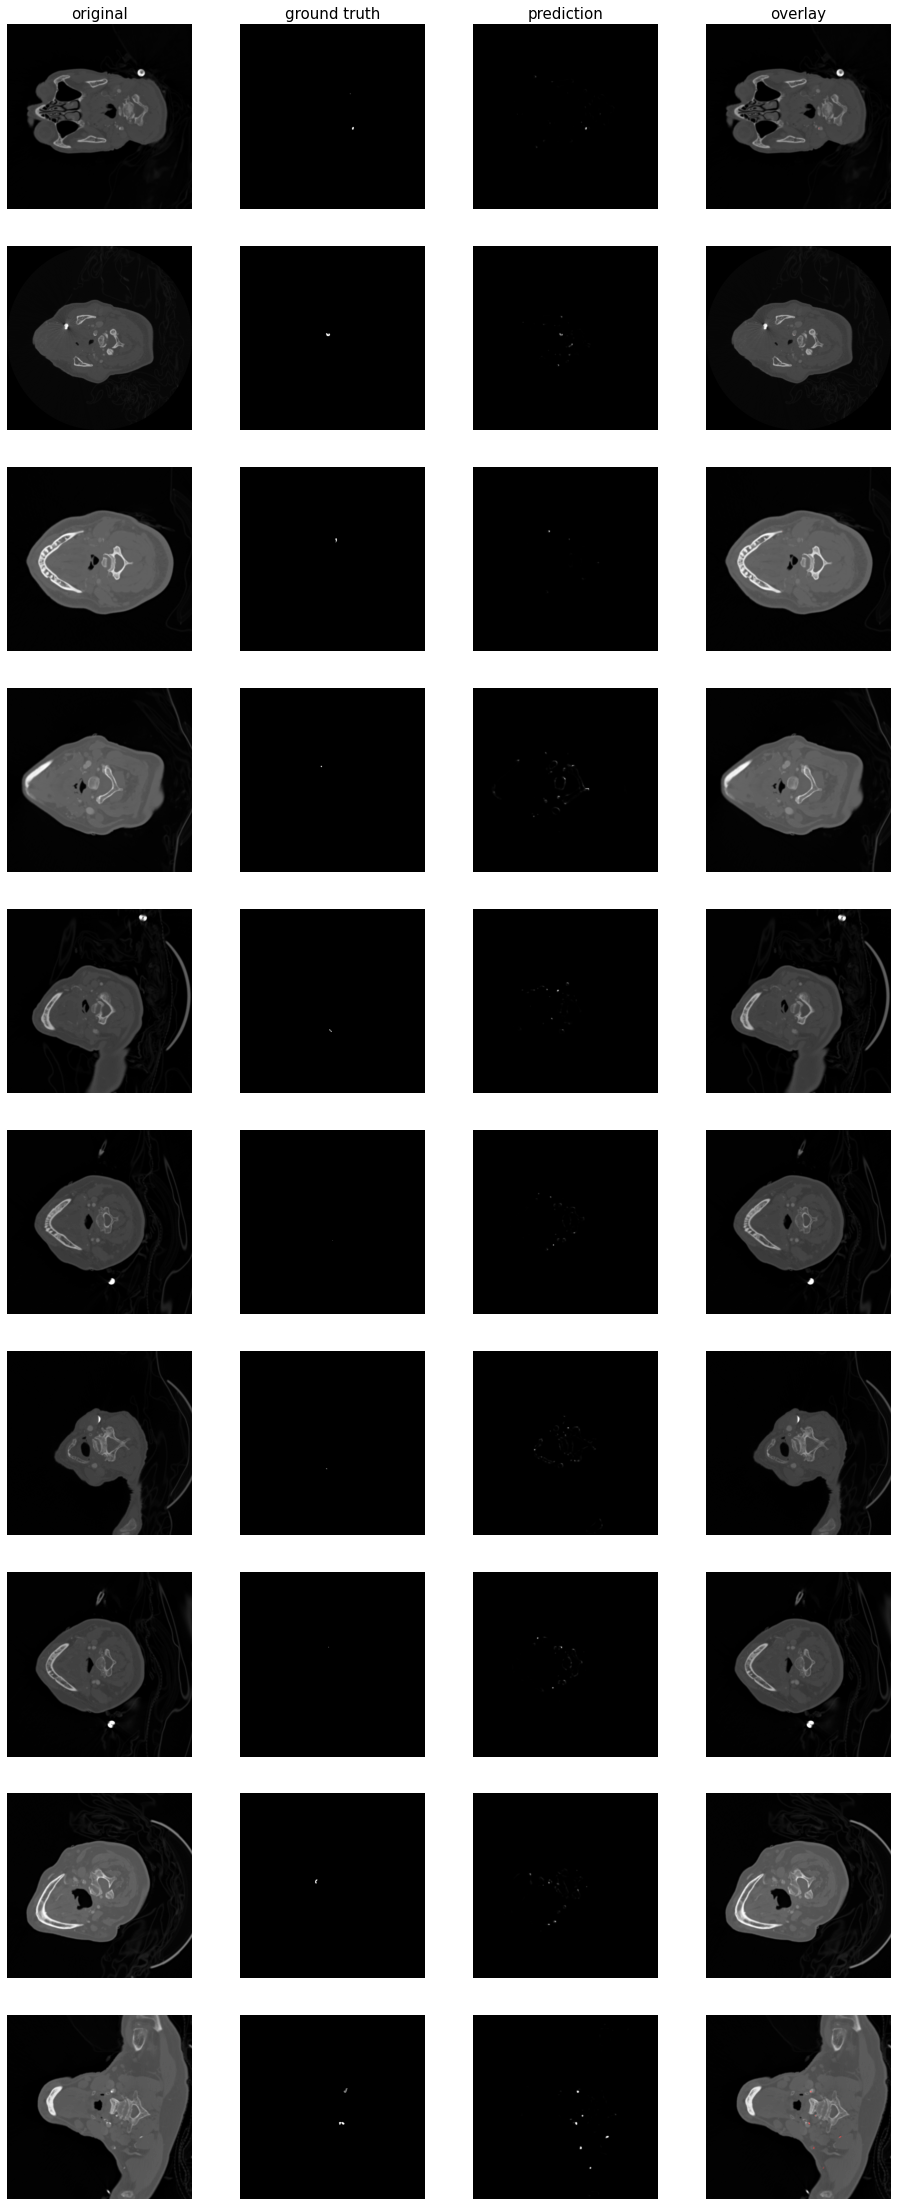

In [22]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=10)

In [23]:
loss, iou, iou_thresholded = model.evaluate(X_val, y_val)

6/6 [==============================] - 1s 184ms/step - loss: 0.0013 - iou: 0.2255 - iou_thresholded: 0.2381
